# TP Cuda

In [41]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd

from typing import List
import subprocess

In [42]:
def compute_metrics(times: np.ndarray) -> np.ndarray:
    # Function to compute the mean, standard deviation and median of the times
    metrics = np.zeros((3, times.shape[0]))

    for j in range(times.shape[0]):
        metrics[0, j] = np.mean(times[j])
        metrics[1, j] = np.std(times[j])
        metrics[2, j] = np.median(times[j])

    return metrics

In [43]:
def plot_dataframe(
    df: pd.DataFrame,
    x_name: str,
    title: str,
    x_label: str,
    y_label: str,
    x_log: bool = False,
    y_log: bool = False
) -> None:
    for i, row in df.iterrows():
        plt.plot(row[x_name], row['metrics'][0], label=row['name'])

    if x_log:
        plt.xscale('log')
    if y_log:
        plt.yscale('log')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

## Part 1: Compute PI

In [ ]:
NB_STEPS = [10**4, 10**5, 10**6, 10**7, 10**8, 10**9, 10**10]
NB_REPEAT = 5

In [ ]:
compute_pi_df = pd.DataFrame(columns=['name', 'executable', 'steps', 'times', 'metrics'])

compute_pi_df.loc[0] = {
    'name': 'One thread per block',
    'executable': 'cuda_part_1/pi_1',
    'steps': [10**4, 10**5, 10**6, 10**7, 10**8],'times': None,'metrics': None
}
compute_pi_df.loc[1] = {
    'name': 'Multiple threads per block',
    'executable': 'cuda_part_1/pi_2',
    'steps': NB_STEPS,'times': None,'metrics': None
}
compute_pi_df.loc[2] = {
    'name': 'Shared memory',
    'executable': 'cuda_part_1/pi_3',
    'steps': NB_STEPS,'times': None,'metrics': None
}


In [46]:
def run_compute_pi(executable_path: str, nb_steps_list: List[int], nb_repeat: int = 1) -> np.ndarray:
    execution_times = np.zeros((len(nb_steps_list), nb_repeat))

    for i, nb_steps in enumerate(tqdm(nb_steps_list)):
        for j in range(nb_repeat):
            command = [executable_path, '-N', str(nb_steps)]

            result = subprocess.run(command, capture_output=True, text=True)
            output = result.stdout
            error = result.stderr

            for line in output.splitlines():
                if 'in' in line:
                    time_str = line.split()[-2]
                    execution_times[i, j] = float(time_str)
                    break

    return execution_times

In [48]:
for i, row in compute_pi_df.iterrows():
    print(f"Benchmarking {row['name']} method")
    row['times'] = run_compute_pi(row['executable'], row['steps'], NB_REPEAT)
    row['metrics'] = compute_metrics(row['times'])

Benchmarking One thread per block method


100%|██████████| 6/6 [00:40<00:00,  6.73s/it]


Benchmarking Multiple threads per block method


100%|██████████| 6/6 [00:06<00:00,  1.15s/it]


Benchmarking Shared memory method


100%|██████████| 6/6 [00:07<00:00,  1.20s/it]


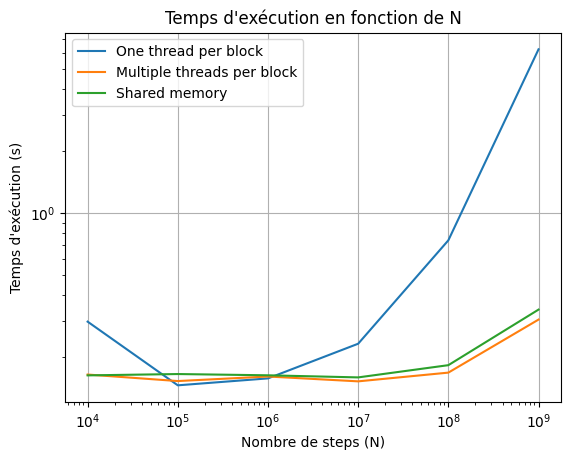

In [52]:
plot_dataframe(
    df=compute_pi_df,
    x_name='steps',
    title='Temps d\'exécution en fonction de N',
    x_label='Nombre de steps (N)',
    y_label='Temps d\'exécution (s)',
    x_log=True,
    y_log=True
)

## Part 2: Matrix-Vector multiplication

Note: to make it easier, we will use N = M but they can be different

In [53]:
M_AND_N = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
NB_REPEAT = 100

In [58]:
matrix_vector_df = pd.DataFrame(columns=['name', 'executable', 'sizes', 'times', 'metrics'])

matrix_vector_df.loc[0] = {
    'name': 'One thread per block',
    'executable': 'cuda_part_2/matvect_1',
    'sizes': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14],'times': None,'metrics': None
}
matrix_vector_df.loc[1] = {
    'name': 'Multiple threads per block',
    'executable': 'cuda_part_2/matvect_2',
    'sizes': M_AND_N,'times': None,'metrics': None
}
matrix_vector_df.loc[2] = {
    'name': 'Shared memory',
    'executable': 'cuda_part_2/matvect_3',
    'sizes': M_AND_N,'times': None,'metrics': None
}


In [59]:
def run_compute_mat_vect(executable_path: str, sizes: List[int], nb_repeat: int = 1) -> np.ndarray:
    execution_times = np.zeros((len(sizes)))

    for i, size in enumerate(tqdm(sizes)):
        command = [executable_path, '-N', str(size), '-M', str(size), '-nrepeat', str(nb_repeat)]

        result = subprocess.run(command, capture_output=True, text=True)
        output = result.stdout
        error = result.stderr

        for line in output.splitlines():
            if 'time' in line:
                time_str = line.split()[15]
                execution_times[i] = float(time_str)
                break

    return execution_times

In [60]:
for i, row in matrix_vector_df.iterrows():
    print(f"Benchmarking {row['name']} method")
    row['times'] = run_compute_mat_vect(row['executable'], row['sizes'], NB_REPEAT)

Benchmarking One thread per block method


100%|██████████| 10/10 [00:19<00:00,  1.94s/it]


Benchmarking Multiple threads per block method


100%|██████████| 11/11 [00:24<00:00,  2.26s/it]


Benchmarking Shared memory method


100%|██████████| 11/11 [00:26<00:00,  2.42s/it]


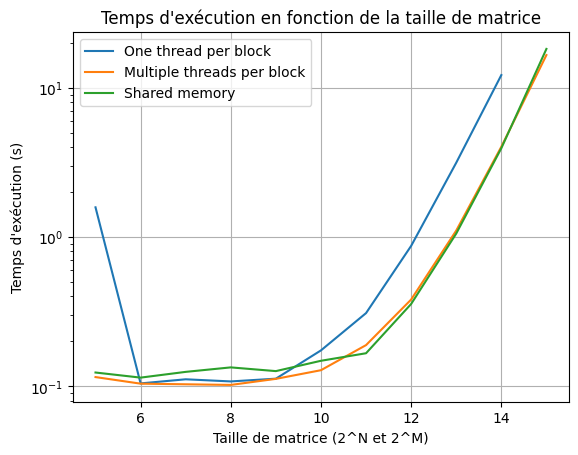

In [61]:
for i, row in matrix_vector_df.iterrows():
    plt.plot(row['sizes'], row['times'], label=row['name'])
plt.yscale('log')
plt.xlabel('Taille de matrice (2^N et 2^M)')
plt.ylabel('Temps d\'exécution (s)')
plt.title('Temps d\'exécution en fonction de la taille de matrice')
plt.legend()
plt.grid()
plt.show()

## Part 3: Matrix-Matrix multiplication

Note: to make it easier, we will use N = M = P but they can be different

In [68]:
SIZES = [10, 50, 100, 500, 1000, 1500, 2000]
NB_REPEAT = 5

In [69]:
matmul_df = pd.DataFrame(columns=['name', 'executable', 'sizes', 'times', 'metrics'])

matmul_df.loc[0] = {
    'name': 'One thread per block',
    'executable': 'cuda_part_3/matmul_1',
    'sizes': SIZES,'times': None,'metrics': None
}
matmul_df.loc[1] = {
    'name': 'Multiple threads per block',
    'executable': 'cuda_part_3/matmul_2',
    'sizes': SIZES,'times': None,'metrics': None
}


In [75]:
def run_compute_matmul(executable_path: str, sizes: List[int], nb_repeat: int = 1) -> np.ndarray:
    execution_times = np.zeros((len(sizes), nb_repeat))

    for i, size in enumerate(tqdm(sizes)):
        for j in range(nb_repeat):
            command = [executable_path, '-N', str(size), '-M', str(size), '-P', str(size)]

            result = subprocess.run(command, capture_output=True, text=True)
            output = result.stdout
            error = result.stderr

            for line in output.splitlines():
                if 'seconds' in line:
                    time_str = line.split()[8]
                    execution_times[i, j] = float(time_str)
                    break

    return execution_times

In [80]:
for i, row in matmul_df.iterrows():
    print(f"Benchmarking {row['name']} method")
    row['times'] = run_compute_matmul(row['executable'], row['sizes'], NB_REPEAT)
    row['metrics'] = compute_metrics(row['times'])

Benchmarking One thread per block method


100%|██████████| 7/7 [00:33<00:00,  4.74s/it]


Benchmarking Multiple threads per block method


100%|██████████| 7/7 [00:27<00:00,  3.92s/it]


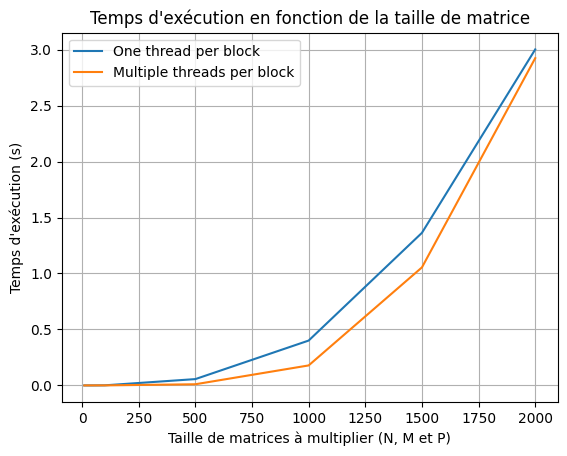

In [81]:
plot_dataframe(
    df=matmul_df,
    x_name='sizes',
    title='Temps d\'exécution en fonction de la taille de matrice',
    x_label='Taille de matrices à multiplier (N, M et P)',
    y_label='Temps d\'exécution (s)',
)